# Content Based Image Retrival

In [1]:
!pip install barbar torchsummary
!pip install opencv-python
import time
import copy
import pickle
from barbar import Bar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchsummary import summary

from tqdm import tqdm
from pathlib import Path
import gc
import os

Data Prep

In [2]:
data_path = Path('archive/dataset/')
df = pd.DataFrame()
df['image'] = [f for f in os.listdir(data_path)]
df['image'] = 'archive/dataset/' + df['image'].astype(str)
df.head()

,image
0,archive/dataset/0.jpg
1,archive/dataset/1.jpg
2,archive/dataset/10.jpg
3,archive/dataset/100.jpg
4,archive/dataset/1000.jpg


In [3]:
class ImageDataSet(Dataset):
  def __new__(cl, *arg, **kwgs):
    pass
  
  def __int__(self, dataFrame):
    self.dataFrame = dataFrame
    self.transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

  def __getitem__(self, key):
    row = self.dataFrame.iloc[key]
    image = self.transformations(Image.open(row['image']))
    return image

  def __len__():
    return len(self.dataFrame.index)

In [4]:
def prepare_data(DF):
    trainDF, validateDF = train_test_split(DF, test_size=0.15, random_state=0)
    train_set = ImageDataSet(trainDF)
    validate_set = ImageDataSet(validateDF)
    
    return train_set, validate_set

Model Prep

In [5]:
#Convolution Bottleneck
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample

    def forward(self, x):
        shortcut = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        if self.downsample is not None:
            shortcut = self.downsample(x)

        out += shortcut
        out = self.relu(out)

        return out

In [6]:
#Deconvolution Bottleneck
class DeconvBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=2, stride=1, upsample=None):
        super(DeconvBottleneck, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if stride == 1:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                                   stride=stride, bias=False, padding=1)
        else:
            self.conv2 = nn.ConvTranspose2d(out_channels, out_channels,
                                            kernel_size=3,
                                            stride=stride, bias=False,
                                            padding=1,
                                            output_padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.upsample = upsample

    def forward(self, x):
        shortcut = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        if self.upsample is not None:
            shortcut = self.upsample(x)

        out += shortcut
        out = self.relu(out)

        return out

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, downblock, upblock, num_layers, n_classes=3):
        super(AutoEncoder, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_downlayer(downblock, 64, num_layers[0])
        self.layer2 = self._make_downlayer(downblock, 128, num_layers[1],
                                           stride=2)
        self.layer3 = self._make_downlayer(downblock, 256, num_layers[2],
                                           stride=2)
        self.layer4 = self._make_downlayer(downblock, 512, num_layers[3],
                                           stride=2)

        self.uplayer1 = self._make_up_block(
            upblock, 512,  num_layers[3], stride=2)
        self.uplayer2 = self._make_up_block(
            upblock, 256, num_layers[2], stride=2)
        self.uplayer3 = self._make_up_block(
            upblock, 128, num_layers[1], stride=2)
        self.uplayer4 = self._make_up_block(
            upblock, 64,  num_layers[0], stride=2)

        upsample = nn.Sequential(
            nn.ConvTranspose2d(self.in_channels,  # 256
                               64,
                               kernel_size=1, stride=2,
                               bias=False, output_padding=1),
            nn.BatchNorm2d(64),
        )
        self.uplayer_top = DeconvBottleneck(
            self.in_channels, 64, 1, 2, upsample)

        self.conv1_1 = nn.ConvTranspose2d(64, n_classes, kernel_size=1, stride=1,
                                          bias=False)

    def _make_downlayer(self, block, init_channels, num_layer, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != init_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, init_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(init_channels * block.expansion),            )
        layers = []
        layers.append(
            block(self.in_channels, init_channels, stride, downsample))
        self.in_channels = init_channels * block.expansion
        for i in range(1, num_layer):
            layers.append(block(self.in_channels, init_channels))

        return nn.Sequential(*layers)

    def _make_up_block(self, block, init_channels, num_layer, stride=1):
        upsample = None
        if stride != 1 or self.in_channels != init_channels * 2:
            upsample = nn.Sequential(
             nn.ConvTranspose2d(self.in_channels, init_channels * 2,
                              kernel_size=1, stride=stride,
                                   bias=False, output_padding=1),
                nn.BatchNorm2d(init_channels * 2),
            )
        layers = []
        for i in range(1, num_layer):
            layers.append(block(self.in_channels, init_channels, 4))
        layers.append(
            block(self.in_channels, init_channels, 2, stride, upsample))
        self.in_channels = init_channels * 2
        return nn.Sequential(*layers)

    def encoder(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        return x

    def decoder(self, x, image_size):
        x = self.uplayer4(x)
        x = self.uplayer_top(x)

        x = self.conv1_1(x, output_size=image_size)
        return x

    def forward(self, x):
        img = x
        tmp1 = self.encoder(x)
        tmp2 = self.decoder(tmp1, img.size())
        tmp3 = self.encoder(tmp2)

        return tmp1, tmp2, tmp3

In [8]:
train_set, validate_set = prepare_data(DF=df)

#dataloaders = {'train': DataLoader(train_set, batch_size=8, num_workers=1) ,
#                'val':DataLoader(validate_set, batch_size=8, num_workers=1)
#                }

model = AutoEncoder(Bottleneck, DeconvBottleneck, [3, 4, 6, 3], 3)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

model.eval()

AutoEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [9]:
summary(AutoEncoder(Bottleneck, DeconvBottleneck, [3, 4, 6, 3], 3), (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
             ReLU-13        [-1, 256, 128, 128]               0
           Conv2d-14        [-1, 256, 1

Obtain training results

In [10]:
def get_latent_features(images, transformations):
    
    latent_features = np.zeros((400,256,128,128))
    
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image))
        latent_features[i] = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()

    del tensor
    gc.collect()
    return latent_features

In [11]:
transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

images = df.image.values[:350]
latent_features = get_latent_features(images, transformations)

100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [01:07<00:00,  5.17it/s]


Search

In [12]:
indexes = list(range(0, 350))
feature_dict = dict(zip(indexes,latent_features))
index_dict = {'indexes':indexes,'features':latent_features}

In [13]:
#Euclidean Distance
def euclidean(a, b):
    return np.linalg.norm(a - b)

In [1]:
#Cosine Distance
def cosine_distance(a,b):
    return scipy.spatial.distance.cosine(a, b)

In [14]:
def search(queryFeatures, index, maxResults=64):

    results = []

    for i in range(0, len(index["features"])):
        # compute the euclidean distance between query feature and image bank features, swap method call if cosine_distance is wanted.
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))
    
    results = sorted(results)[:maxResults]
    
    return results

In [15]:
def build_result(image_list, image_shape, montage_shape):

    image_results = []
   
    results_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        
        results_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1] 
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_results.append(results_image)
                
                results_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_results.append(results_image)
    return image_results

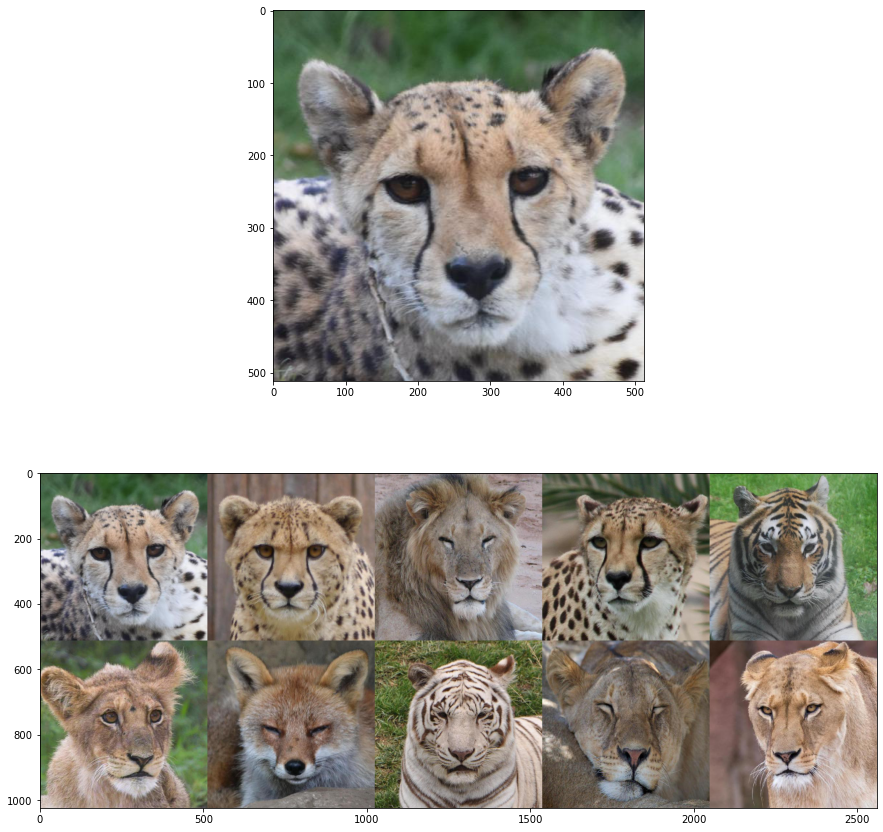

In [16]:
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
queryIdx = 33 #Index for Query image
MAX_RESULTS = 10


queryFeatures = latent_features[queryIdx]
results = search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(images[queryIdx])))

# build a montage from the results and display it
montage = build_result(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)

Test Run with image outside of databank

In [17]:
new_data_path = Path('test/')
test_df = pd.DataFrame()
test_df['image'] = [f for f in os.listdir(new_data_path)]
test_df['image'] = 'test/' + test_df['image'].astype(str)
test_df.head()

,image
0,test/test.jpg


In [18]:
q_features = np.zeros((1,256,128,128))
q_image = test_df.iloc[0]

for i,image in enumerate(tqdm(q_image)):
    img = Image.open(image)
    img = img.resize((512,512),Image.ANTIALIAS)
    q_image = img                         

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.36it/s]


In [24]:
tensor = transformations(q_image)
q_features[0] = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()

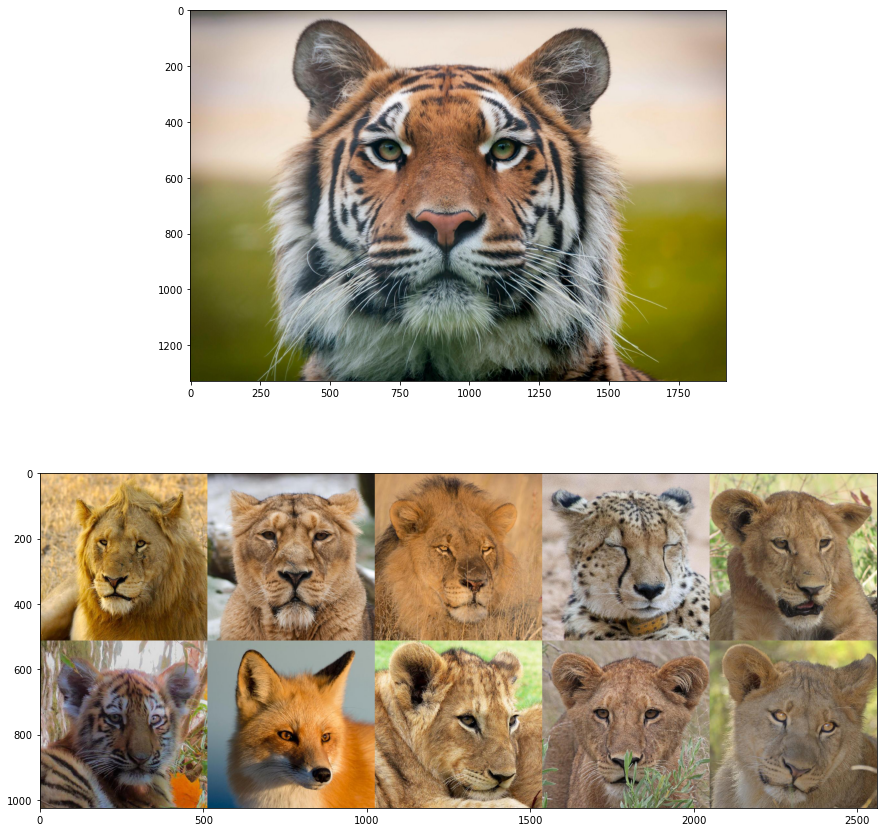

In [23]:
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
MAX_RESULTS = 10


newFeatures = q_features[0]
results = search(newFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open('test/test.jpg')))

# build a montage from the results and display it
montage = build_result(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)